# 标准Unet网络
0. [kaggle上解压、读取数据集](#ch1)
0. [可视化](#ch2)
0. [resize图片大小](#ch3)
0. [unet网络搭建](#ch4)
0. [预测](#ch5)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf

from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline
import cv2
from PIL import Image

<a id='ch1'></a>
# 0.解压、读取数据(适用kaggle平台) 

In [3]:
import zipfile
#解压训练集图像
with zipfile.ZipFile('../input/carvana-image-masking-challenge/train_hq.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('../input/carvana-image-masking-challenge/train_masks.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('../input/carvana-image-masking-challenge/train.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('../input/carvana-image-masking-challenge/metadata.csv.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [4]:
data_size = len(os.listdir('/kaggle/working/train_hq'))
print('训练集size:',data_size)

训练集size: 5088


In [5]:
import os
from glob import glob
train_files=glob(os.path.join('/kaggle/working/train','*.jpg'))
#解释：遍历文件夹下所有jpg文件
train_ids=[s[len('/kaggle/working/train')+1:-4] for s in train_files]
#去除文件的前缀，后缀

In [6]:
all_images = os.listdir('/kaggle/working/train_hq')
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

In [7]:
car_ids=sorted(os.listdir('/kaggle/working/train_hq'))
mask_ids=sorted(os.listdir('/kaggle/working/train_masks'))
rnd_ids=list(np.random.choice(data_size,8))
for i in rnd_ids:
    print('训练图片:{},对应标注图片:{}'.format(car_ids[i],mask_ids[i]))

训练图片:1aba91a601c6_02.jpg,对应标注图片:1aba91a601c6_02_mask.gif
训练图片:4856fcb85be0_10.jpg,对应标注图片:4856fcb85be0_10_mask.gif
训练图片:66fea07e1152_09.jpg,对应标注图片:66fea07e1152_09_mask.gif
训练图片:78f63d808555_05.jpg,对应标注图片:78f63d808555_05_mask.gif
训练图片:0de66245f268_13.jpg,对应标注图片:0de66245f268_13_mask.gif
训练图片:85bc655a7523_03.jpg,对应标注图片:85bc655a7523_03_mask.gif
训练图片:5bcde75955bb_16.jpg,对应标注图片:5bcde75955bb_16_mask.gif
训练图片:b1a27da4f01c_15.jpg,对应标注图片:b1a27da4f01c_15_mask.gif


<a id='ch2'></a>
# 1.可视化

Image Size:  (1918, 1280)
Mask Size:  (1918, 1280)


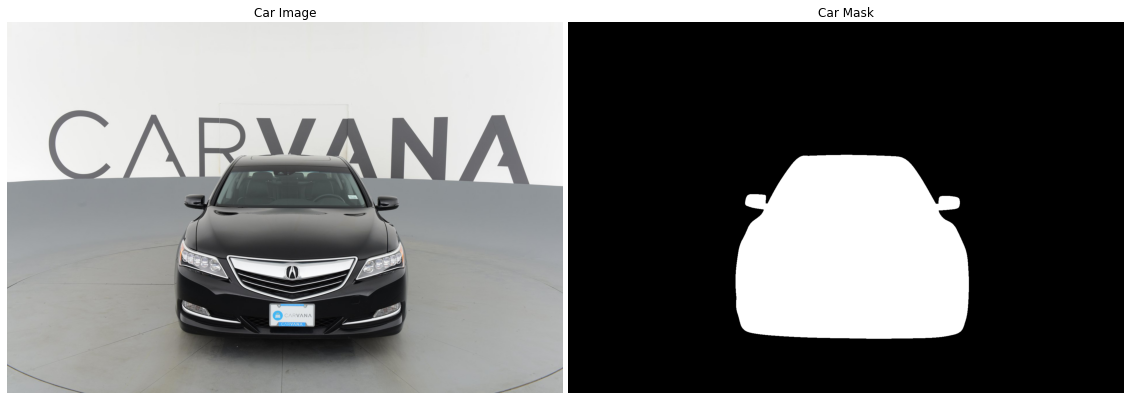

In [8]:
car_id=car_ids[0]
mask_id=mask_ids[0]
car=load_img('/kaggle/working/train_hq/' + car_id)
mask=load_img('/kaggle/working/train_masks/' + mask_id)
print('Image Size:' ,car.size)
print('Mask Size:' ,mask.size)
fig, ax=plt.subplots(1, 2, figsize=(20,20))
fig.subplots_adjust(hspace=0.1, wspace=0.01)
ax[0].imshow(car)
ax[0].axis('off')
ax[0].title.set_text('Car Image')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].title.set_text('Car Mask')

In [9]:
from sklearn.model_selection import train_test_split
X_train_ids, X_val_ids, y_train_ids, y_val_ids= train_test_split(car_ids, mask_ids,
                                                                 test_size=.2, train_size=.8,
                                                                 random_state=42)
X_train_size=len(X_train_ids)
X_val_size=len(X_val_ids)
print('Training images size:', X_train_size)
print('Validation images size:', X_val_size)

Training images size: 4070
Validation images size: 1018


<a id='ch3'></a>
# 2.Resize
<kbd>这里有个问题：</kbd>
    
   > 对于图片处理来说【128,128】是常用随便设的吗？我这里试过[256,256],然后出现了ResourceExhaustedError；

In [10]:
input_size=[128,128,3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    data_size=len(image_ids)
    while True:
        rnd_ind=np.random.choice(np.arange(data_size),batch_size)
        imgs=[]
        masks=[]
        for i in rnd_ind:
            img_id, mask_id = image_ids[i], mask_ids[i]
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

<a id='ch4'></a>
# 3.U-net
> 只下载了训练5次的版本，10次的结果下载不下来。

In [12]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [13]:

def Unet(input_shape=(128,128, 3)):
    inputs=Input(shape=input_shape)

    down1=Conv2D(64, (3, 3), padding='same')(inputs)
    down1=BatchNormalization()(down1)
    down1=Activation('relu')(down1)
    down1=Conv2D(64, (3, 3), padding='same')(down1)
    down1=BatchNormalization()(down1)
    down1=Activation('relu')(down1)
    down1_pool=MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2=Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2=BatchNormalization()(down2)
    down2=Activation('relu')(down2)
    down2=Conv2D(128, (3, 3), padding='same')(down2)
    down2=BatchNormalization()(down2)
    down2=Activation('relu')(down2)
    down2_pool=MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3=Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3=BatchNormalization()(down3)
    down3=Activation('relu')(down3)
    down3=Conv2D(256, (3, 3), padding='same')(down3)
    down3=BatchNormalization()(down3)
    down3=Activation('relu')(down3)
    down3_pool=MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4=Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4=BatchNormalization()(down4)
    down4=Activation('relu')(down4)
    down4=Conv2D(512, (3, 3), padding='same')(down4)
    down4=BatchNormalization()(down4)
    down4=Activation('relu')(down4)
    down4_pool=MaxPooling2D((2, 2), strides=(2, 2))(down4)

    center=Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center=BatchNormalization()(center)
    center=Activation('relu')(center)
    center=Conv2D(1024, (3, 3), padding='same')(center)
    center=BatchNormalization()(center)
    center=Activation('relu')(center)

    up4=UpSampling2D((2, 2))(center)
    up4=concatenate([down4, up4], axis=3)
    up4=Conv2D(512, (3, 3), padding='same')(up4)
    up4=BatchNormalization()(up4)
    up4=Activation('relu')(up4)
    up4=Conv2D(512, (3, 3), padding='same')(up4)
    up4=BatchNormalization()(up4)
    up4=Activation('relu')(up4)
    

    up3=UpSampling2D((2, 2))(up4)
    up3=concatenate([down3, up3], axis=3)
    up3=Conv2D(256, (3, 3), padding='same')(up3)
    up3=BatchNormalization()(up3)
    up3=Activation('relu')(up3)
    up3=Conv2D(256, (3, 3), padding='same')(up3)
    up3=BatchNormalization()(up3)
    up3=Activation('relu')(up3)

    up2=UpSampling2D((2, 2))(up3)
    up2=concatenate([down2, up2], axis=3)
    up2=Conv2D(128, (3, 3), padding='same')(up2)
    up2=BatchNormalization()(up2)
    up2=Activation('relu')(up2)
    up2=Conv2D(128, (3, 3), padding='same')(up2)
    up2=BatchNormalization()(up2)
    up2=Activation('relu')(up2)
   

    up1=UpSampling2D((2, 2))(up2)
    up1=concatenate([down1, up1], axis=3)
    up1=Conv2D(64, (3, 3), padding='same')(up1)
    up1=BatchNormalization()(up1)
    up1=Activation('relu')(up1)
    up1=Conv2D(64, (3, 3), padding='same')(up1)
    up1=BatchNormalization()(up1)
    up1=Activation('relu')(up1)
    

    
    out=Conv2D(1, (1, 1), activation='sigmoid')(up1)

    model=Model(inputs=inputs, outputs=out)

    model.compile(optimizer='adam', loss='mse', metrics=[dice_coef])

    return model

model=Unet()

![unet](../photo/unet1.jpg)

#### 4000个训练样本，100批，所以batch_size=40

In [14]:
X_train_size
#4000/40=100

4070

In [15]:
batch_size=40
train_gen=data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                           X_train_ids, y_train_ids, batch_size=batch_size)

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#查看平台硬件

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7653595063056955429
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7064396163464088064
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15687541056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6534201806665798366
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10954104995058213745
physical_device_desc: "device: XLA_GPU device"
]


In [17]:
model.fit_generator(train_gen, steps_per_epoch=100,epochs=5)
#拥有越高性能的GPU，则可以设置越大的batch_size值。
#根据现有硬件，我们设置了每批次输入50-100张图像。
#参数steps_per_epoch是通过把训练图像的数量除以批次大小得出的。
#有4070(4000)张图像且批次大小为40，则steps_per_epoch值为100。
#参数epoch决定网络中所有图像的训练次数。
#在Tesla K80 GPU上，大约需要11小时才能完成对1万张图像的21次训练。

Epoch 1/5
100/100 [==============================] - 159s 2s/step - loss: 0.0178 - dice_coef: 0.9441
Epoch 2/5
100/100 [==============================] - 160s 2s/step - loss: 0.0060 - dice_coef: 0.9812
Epoch 3/5
100/100 [==============================] - 161s 2s/step - loss: 0.0048 - dice_coef: 0.9848
Epoch 4/5
100/100 [==============================] - 160s 2s/step - loss: 0.0041 - dice_coef: 0.9872
Epoch 5/5
100/100 [==============================] - 160s 2s/step - loss: 0.0037 - dice_coef: 0.9884


In [18]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 64) 0           batch_normalization_18[0][0]     
_______________________________________________________________________________________

In [19]:
gen = data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                    X_val_ids, y_val_ids, batch_size=32)

imgs, masks = next(gen)
print('Images batch shape: ', imgs.shape)
print('Masks batch shape: ', masks.shape)
pred_masks = model.predict(imgs)

Images batch shape:  (32, 128, 128, 3)
Masks batch shape:  (32, 128, 128, 1)


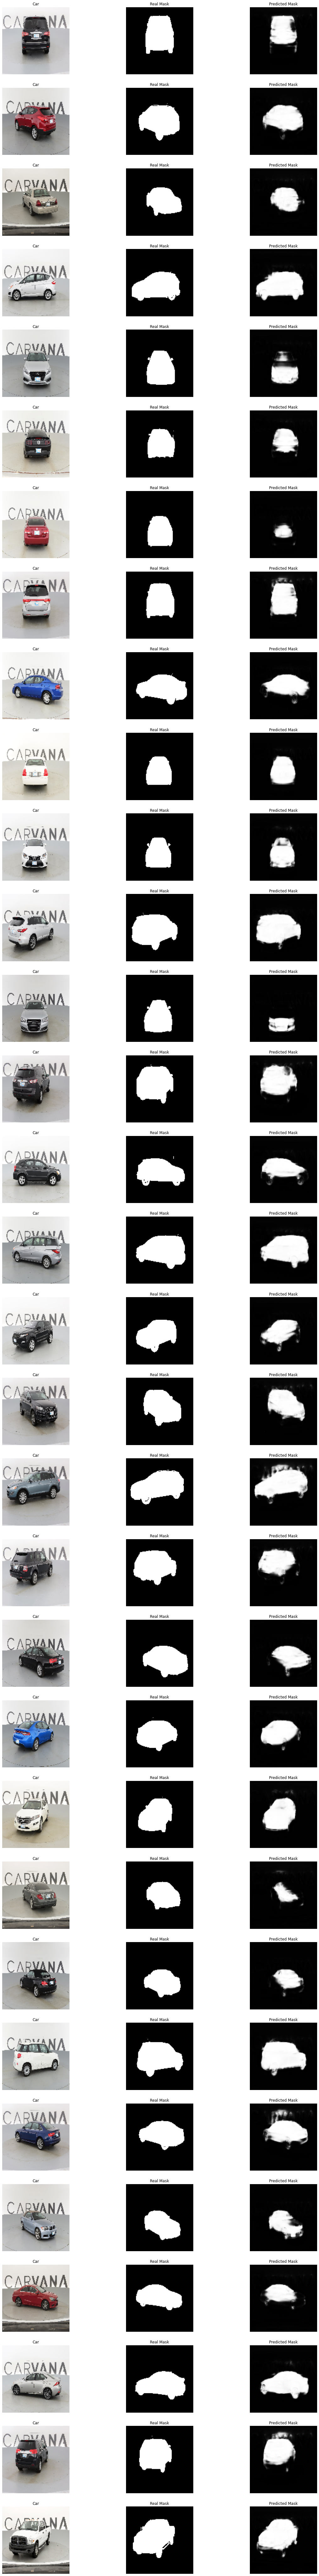

In [20]:
fig, ax=plt.subplots(32, 3, figsize=(20,150))
for i in range(32):
    ax[i, 0].imshow(imgs[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
    ax[i, 1].imshow(masks[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 

<a id='ch5'></a>
# 4.预测

In [ ]:
#解压测试集图像
with zipfile.ZipFile('../input/carvana-image-masking-challenge/test_hq.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('../input/carvana-image-masking-challenge/test.zip','r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

test_ids=sorted(os.listdir('/kaggle/working/test_hq'))

In [ ]:
def pre_data_generator(images_path,image_ids,batch_size, img_size=input_size):
    data_size = len(image_ids)
    while True:
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        for i in rnd_ind:
            img = load_img(images_path + image_ids[i], target_size=img_size) 
            imgs.append(img_to_array(img))
        yield np.array(imgs, dtype=np.float16) / 255.
        
pre_gen=pre_data_generator('/kaggle/working/test_hq',test_ids,batch_size=)
test_imgs=next(pre_gen)
pred_masks = model.predict(test_imgs)

In [ ]:

#with zipfile.ZipFile('/kaggle/working/submission.zip', 'w') as z:
#   z.write(pred_masks)
